# Keras Scikit-learn wrapper class for utilizing cross-validation, grid search etc.
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536

Keras offer a couple of special wrapper classes - for regression and classification - to utilize the full power of Scikit-learn cross-validation, model selection, pipelining, and grid search abilities.

To learn more, see this link: https://keras.io/scikit-learn-api/

In this notebook, we will show demo example of using simple k-fold cross-validation and grid search with a Keras classifier model.

**NOTE**: If you have latest version of NumPy, you will get lots of warning with Keras. You can supress them in the notebook if you want

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# MLP for Pima Indians Dataset with 10-fold cross validation via sklearn
import tensorflow as tf

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import minmax_scale
import numpy as np
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']=150

## Example of 10-fold cross-validation with a Keras classifier

### Function to create Keras model

In [4]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(30, input_dim=8, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

### Load pima indians dataset

In [5]:
dataset = np.loadtxt("..\Data\pima-indian-diabetes.csv", delimiter=",",skiprows=1)

### Split into input (X) and output (Y) variables, scale the X variables for better accuracy

In [6]:
X = dataset[:,0:8]
Y = dataset[:,8]

In [7]:
X_scaled = minmax_scale(X)

### Create the model using `KerasClassifier` class
Here, you pass on the `create_model` function, and other hyperparameters like epochs, and batch size.

Later, we will see how to also pass on those hyperparameters to this class for a grid search. 

In [8]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, 
                        epochs=10, 
                        batch_size=32, 
                        verbose=0)

### Evaluate using 10-fold cross validation

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, 
                        shuffle=True)

In [45]:
cv_results = cross_val_score(model, 
                          X_scaled, Y, 
                          cv=kfold,
                          verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ................................................. , total=   0.5s
[CV]  ................................................................
[CV] ................................................. , total=   0.5s
[CV]  ................................................................
[CV] ................................................. , total=   0.5s
[CV]  ................................................................
[CV] ................................................. , total=   0.5s
[CV]  ................................................................
[CV] ................................................. , total=   0.5s
[CV]  ................................................................
[CV] ................................................. , total=   0.5s
[CV]  ................................................................
[CV] ................................................. , total=   0.5s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


### Extract the mean and standard deviation of the cross-validation splits' scores

In [48]:
print(round(cv_results.mean(),3))

0.691


In [49]:
print(round(cv_results.std(),3))

0.028


## Example of an exhaustive grid search with a Keras classifier

### A model definition with extra arguments

In [13]:
def create_model_grid(activation = 'relu', 
                      optimizer='rmsprop', 
                      init='glorot_uniform'):
    # create model
    model = Sequential()
    
    if activation=='relu':
        model.add(Dense(12, input_dim=8, 
                        kernel_initializer=init, activation='relu'))
        model.add(Dense(8, kernel_initializer=init, activation='relu'))
    if activation=='tanh':
        model.add(Dense(12, input_dim=8, 
                        kernel_initializer=init, activation='tanh'))
        model.add(Dense(8, kernel_initializer=init, activation='tanh'))
    if activation=='sigmoid':
        model.add(Dense(12, input_dim=8, 
                        kernel_initializer=init, activation='sigmoid'))
        model.add(Dense(8, kernel_initializer=init, activation='sigmoid'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

In [14]:
model_grid = KerasClassifier(build_fn=create_model_grid, 
                             verbose=0)

### Grid search epochs, batch size and optimizer

We decide to make the exhaustive hyperparameter search space size as $3 \times 3 \times 3 \times 3 \times 3 = 243$

Note that the **actual number of Keras runs will also depend on the number of cross-validation** we choose, as cross-validation will be used for each of these combinations.

In [16]:
activations = ['tanh','relu','sigmoid']
optimizers = ['rmsprop', 'adam','sgd']
initializers = ['glorot_uniform', 'normal', 'uniform']
epochs = [5,10,25]
batches = [8,16,64]

### Create a dictionary of parameters and pass that to the `GridSearchCV` function as `param_grid`
It is advisable to turn on verbosity at this stage to keep track of what's going on. Remember to keep the `verbose=0` for the main `KerasClassifier` class though, as you probably don't want to display all the gory details of training individual epcohs.

By default, GridSearchCV runs a 3-fold corss-validation if the `cv` parameter is not specified explicitly. The number of cross-validation is going to change to 5 in the next v0.22 of scikit-learn.

To know more about the Grid search function, see the following link: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(activation =  activations,
                  optimizer=optimizers, 
                  epochs=epochs, 
                  batch_size=batches, 
                  init=initializers)

grid = GridSearchCV(estimator=model_grid, 
                    param_grid=param_grid,
                    cv = 3,
                    verbose=2,)

In [18]:
grid

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000226F8DADEB8>,
             param_grid={'activation': ['tanh', 'relu', 'sigmoid'],
                         'batch_size': [8, 16, 64], 'epochs': [5, 10, 25],
                         'init': ['glorot_uniform', 'normal', 'uniform'],
                         'optimizer': ['rmsprop', 'adam', 'sgd']},
             verbose=2)

### Fit (search) the grid
This may take a while depending on the base model architecture, dataset size, and your hardware config.

In [19]:
grid_result = grid.fit(X_scaled, Y)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=rmsprop 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=rmsprop, total=   0.6s
[CV] activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=rmsprop 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=rmsprop, total=   0.6s
[CV] activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=rmsprop 
[CV]  activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=rmsprop, total=   0.8s
[CV] activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=adam 
[CV]  activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=adam, total=   0.5s
[CV] activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=adam 
[CV]  activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=adam, total=   0.5s
[CV] activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=adam 
[CV]  activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=adam, total=   0.5s
[CV] activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=sgd 
[CV]  activation=tanh, batch_size=8, epochs=5, init=glorot_uniform, optimizer=sgd, tota

[Parallel(n_jobs=1)]: Done 729 out of 729 | elapsed:  8.0min finished


### Print the best accuracy result

In [55]:
print("Best accuracy: {}\nBest combination: {}".format(grid_result.best_score_, 
                             grid_result.best_params_))

Best accuracy: 0.75390625
Best combination: {'activation': 'tanh', 'batch_size': 8, 'epochs': 25, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}


### Extract all the results (both mean and std. dev for the cross-validation runs)

In [21]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

### Create a dataframe/table of all the runs with accuracy metric for analyzing later

In [22]:
import pandas as pd

In [23]:
d=pd.DataFrame(params)
d['Mean']=means
d['Std. Dev']=stds

,activation,batch_size,epochs,init,optimizer,Mean,Std. Dev
0,tanh,8,5,glorot_uniform,rmsprop,0.652344,0.022999
1,tanh,8,5,glorot_uniform,adam,0.648438,0.011500
2,tanh,8,5,glorot_uniform,sgd,0.651042,0.024774
3,tanh,8,5,normal,rmsprop,0.651042,0.024774
4,tanh,8,5,normal,adam,0.651042,0.024774
...,...,...,...,...,...,...,...
238,sigmoid,64,25,normal,adam,0.651042,0.024774
239,sigmoid,64,25,normal,sgd,0.651042,0.024774
240,sigmoid,64,25,uniform,rmsprop,0.651042,0.024774
241,sigmoid,64,25,uniform,adam,0.651042,0.024774


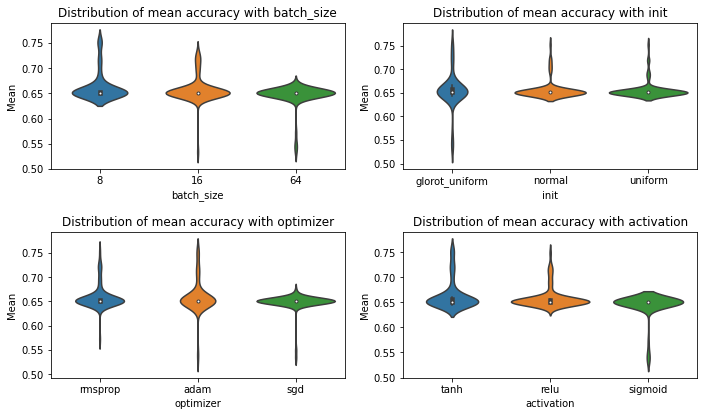

In [67]:
param_ = ['batch_size','init','optimizer','activation']
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2,figsize=(10,6), squeeze=False)
ax = ax.ravel()
for i in range(4):
    ax[i].set_title('Distribution of mean accuracy with {}'.format(param_[i]))
    sns.violinplot(x=param_[i],y='Mean',data=d,ax=ax[i])
fig.tight_layout(pad=1.5)

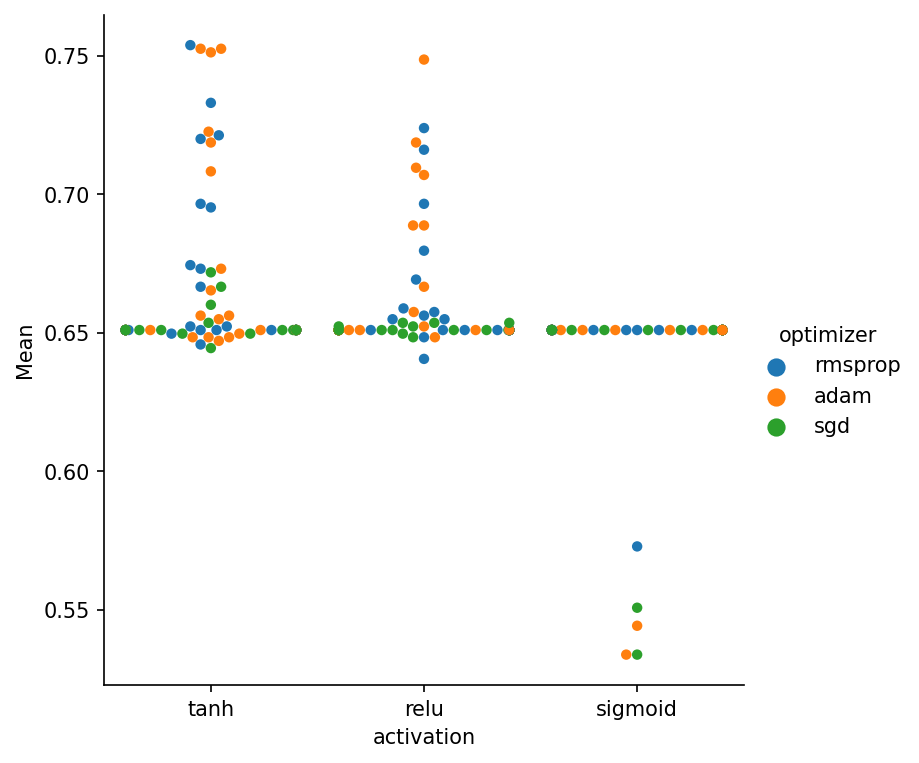

In [77]:
sns.catplot(x="activation", y="Mean", hue="optimizer", kind="swarm", data=d)